In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def scrape_data():
    os.system('python3 ./scraper/main-scraper.py')
    print('Done')
    
def resample_data(Trading_ID = "BTC-USDT"):
    the_path = os.getcwd()
    data_path = the_path + '/data/processed-data/'
    file_name = Trading_ID + '-processed.csv'
    file_path = data_path + file_name
    df = pd.read_csv(file_path, index_col='Date')
    df.drop(df.columns[df.columns.str.contains('unnamed: 0',case = False)],axis = 1,inplace = True)
    L_df = []
    L_freq = ['5min', '10min', '15min', '30min', '60min', '2H', '3H', '5H', '8H', '12H', '24H']
    # 5 min
    range_5min = pd.date_range(end=df.index[-1], periods=8000, freq='5T')
    df_5min = df[str(range_5min[0]):]
    L_df.append(df_5min)
    # 10 min
    range_10min = pd.date_range(end=df.index[-1], periods=25920, freq='10T')
    df_10min = df[str(range_10min[0]):]
    L_df.append(df_10min)
    # 15 min
    range_15min = pd.date_range(end=df.index[-1], periods=8000, freq='15T')
    df_15min = df[str(range_15min[0]):]
    L_df.append(df_15min)
    # 30 min
    range_30min = pd.date_range(end=df.index[-1], periods=8000, freq='30T')
    df_30min = df[str(range_30min[0]):]
    L_df.append(df_30min)
    # 60 min
    range_60min = pd.date_range(end=df.index[-1], periods=8000, freq='60T')
    df_60min = df[str(range_60min[0]):]
    L_df.append(df_60min)
    # 2 hrs
    range_2hrs = pd.date_range(end=df.index[-1], periods=8000, freq='2H')
    df_2hrs = df[str(range_2hrs[0]):]
    L_df.append(df_2hrs)
    # 3 hrs
    range_3hrs = pd.date_range(end=df.index[-1], periods=8000, freq='3H')
    df_3hrs = df[str(range_3hrs[0]):]
    L_df.append(df_3hrs)
    # 5 hrs
    df_5hrs = df[str(pd.Timestamp(df.index[-1]) - pd.offsets.Day(730)):]
    L_df.append(df_5hrs)
    # 8 hrs
    df_8hrs = df[str(pd.Timestamp(df.index[-1]) - pd.offsets.Day(730)):]
    L_df.append(df_8hrs)
    # 12 hrs
    df_12hrs = df[str(pd.Timestamp(df.index[-1]) - pd.offsets.Day(730)):]
    L_df.append(df_12hrs)
    # 24 hrs
    df_24hrs = df[str(pd.Timestamp(df.index[-1]) - pd.offsets.Day(730)):]
    L_df.append(df_24hrs)
    for dataframe, frequency in zip(L_df, L_freq):
        values = dataframe['Average'].values
        ts = pd.Series(values, index=dataframe.index)
        ts.index = pd.to_datetime(ts.index)
        ts = ts[~ts.index.duplicated()]
        ts[ts==-1] = np.nan
        newFreq=ts.resample(frequency).asfreq()
        new = (ts.reindex(ts.index | newFreq.index)
               .interpolate(method='time')
               .loc[newFreq.index])
        file_name = Trading_ID + '_resampled_' + frequency + '.csv'
        file_path = data_path + file_name
        new.to_csv(file_path)
    print('DONE!')

In [3]:
def get_data(frequency = '10min', time = '180D'):
    the_path = os.getcwd()
    data_path = the_path + '/data/processed-data/'
    file_name  = 'BTC-USDT_resampled_' + frequency + '.csv'
    file_path = data_path + file_name
    df_data = pd.read_csv(file_path) 
    df_data.columns = ['Date', 'Average']
    df_data['Date'] = pd.to_datetime(df_data['Date'])
    df_data.index = df_data['Date']
    new_df = df_data.last(time).copy()
    new_df.rename(columns={'Date': 'ds', 'Average': 'y'}, inplace=True)
    new_df['y'] = np.log(new_df['y'])
    return new_df

def get_model_data(df, time = '4308H'):
    return df.first(time).copy()

def get_testing_data(df, time = '12H'):
    return df.last(time).copy()
    
def get_prediction(m, n = 72, frequency = '10min'):
    future = m.make_future_dataframe(periods = n, freq = frequency)
    forecast = m.predict(future)
    return forecast

def fit_model(df, cps = 0.5):
    m = Prophet(changepoint_prior_scale = cps)
    m.fit(df)
    return m

#TODO make comparisons
def compare(forecast, real_data):
    metric_df = forecast.set_index('ds')[['yhat']].join(real_data.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    print (r2_score(np.exp(metric_df.y), np.exp(metric_df.yhat)))
    print (mean_squared_error(np.exp(metric_df.y), np.exp(metric_df.yhat)))
    print (mean_absolute_error(np.exp(metric_df.y), np.exp(metric_df.yhat)))
    return metric_df

In [4]:
scrape_data()

Done


In [5]:
resample_data()

DONE!


In [6]:
df = get_data()

In [7]:
model_df = get_model_data(df)
testing_df = get_testing_data(df)

In [8]:
m = fit_model(model_df)
forecast = get_prediction(m)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [9]:
metric_df = compare(forecast, testing_df)

-100.48023221447565
23455.861284663828
152.60105978554364


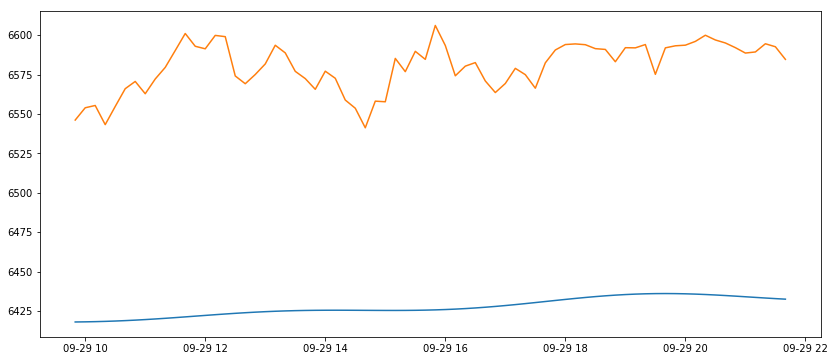

In [10]:
plt.figure(figsize=(14,6))
plt.plot(metric_df['ds'], np.exp(metric_df['yhat']))
#plt.plot(metric_df['ds'], np.exp(forecast['yhat_lower'].last('1D')))
#plt.plot(metric_df['ds'], np.exp(forecast['yhat_upper'].last('1D')))
plt.plot(metric_df['ds'], np.exp(metric_df['y']))
plt.show()

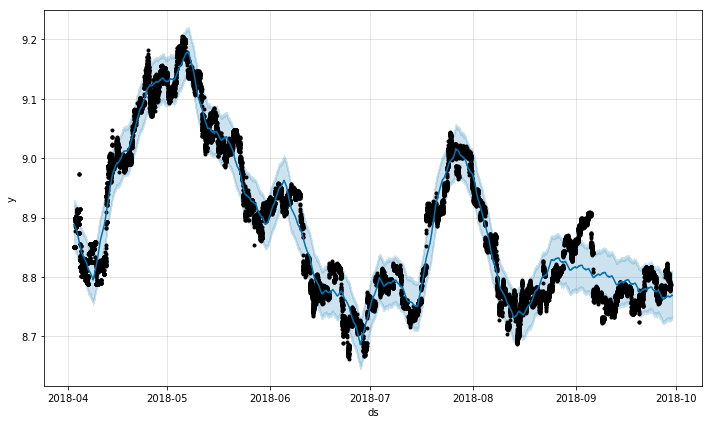

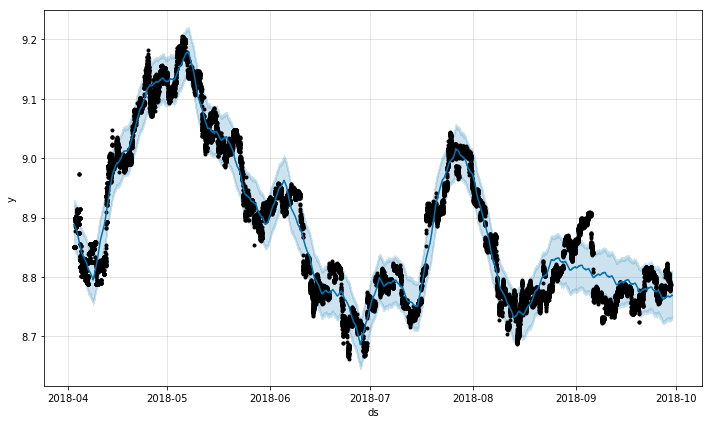

In [11]:
m.plot(forecast)

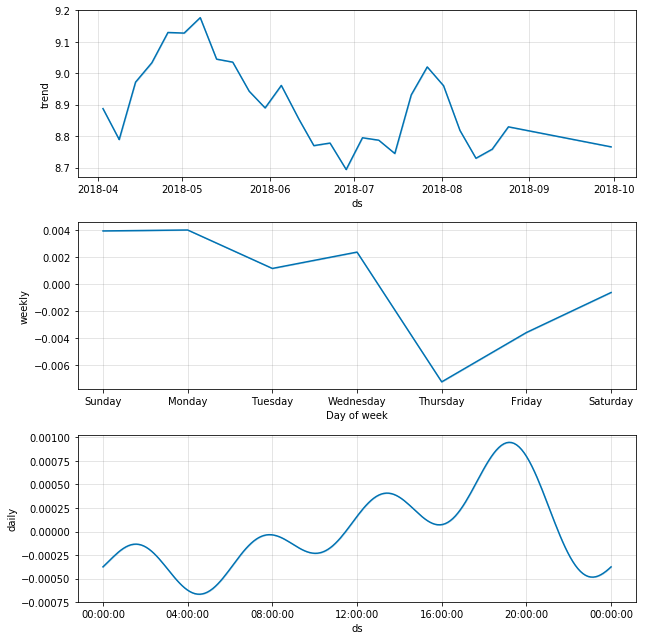

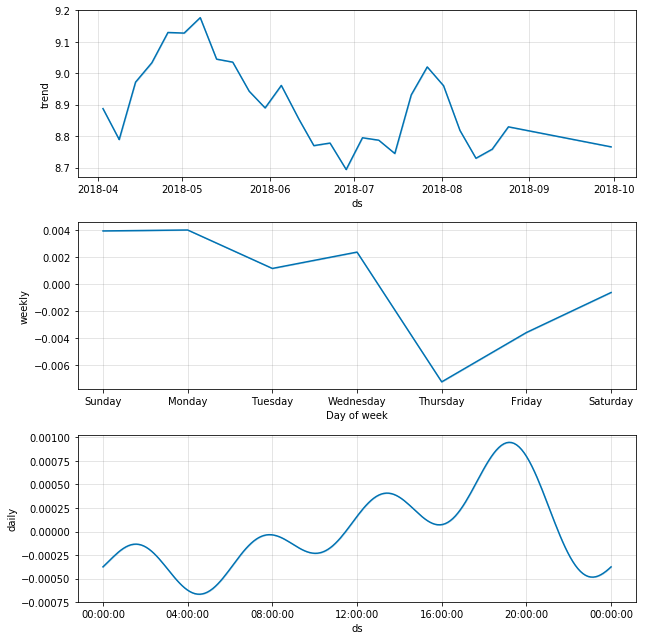

In [12]:
m.plot_components(forecast)